In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import site

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import rioxarray as rxr

import cryogrid_pytools as cg_pt
import cryogrid_run_manager as cg_rm

In [3]:
bbox_WSEN = 71.537796,39.627680,71.680705,39.707624

In [4]:
# cg_rm.templater.main(
#     '../runs/abramov-tmp/',
#     bbox_WSEN=bbox_WSEN,
#     template_dir='../templates/',
#     n_land_classes=3,
# )

In [10]:
# out = cg_rm.report.main.create_report(
#     dirname_experiment="../runs/abramov-small-3classes/",
#     dirname_profiles="../runs/abramov-small-3classes/outputs/organics_running-20250313/",
# )

In [4]:
fname_config = '../runs/abramov-small-3classes/abramov-small-3classes.xlsx'
fname_spatial = '../runs/abramov-small-3classes/outputs/organics_running-20250313/run_spatial_info.mat'
fname_profiles = '../runs/abramov-small-3classes/outputs/organics_running-20250313/abramov-small-3classes_{index}_*.mat'

config = cg_pt.CryoGridConfigExcel(fname_config, check_file_paths=False, check_strat_layers=False)
ds_spatial = cg_pt.read_mat_struct_as_dataset(fname_spatial, drop_keys=['cluster_idx'])

2025-03-31 16:14:49.786 | INFO     | cryogrid_pytools.excel_config:_get_root_path:70 - Found root path: /Users/luke/Git/CryoGrid-run-manager/runs/abramov-small-3classes


2025-03-31 16:14:49.941 | SUCCESS  | cryogrid_pytools.excel_config:__init__:37 - Loaded CryoGrid Excel configuration file: /Users/luke/Git/CryoGrid-run-manager/runs/abramov-small-3classes/abramov-small-3classes.xlsx
2025-03-31 16:14:49.958 | INFO     | cryogrid_pytools.excel_config:__init__:52 - Start and end times: 1960-01-01 - 2020-09-01


In [15]:
indicies = np.sort(ds_spatial.cluster_idx.values)

In [193]:
depth = np.arange(-20, 5.01, 0.05)[::-1]

analysis_all = []
for c, idx in enumerate(indicies):
    fname = fname_profiles.format(index=idx)
    print(f"{c:03d}", fname)
    
    ds = cg_pt.read_OUT_regridded_clusters(fname, -config.get_output_max_depth(), verbose=0)

    # class_ice = ds.class_number.max().compute().item()
    # mask = (ds.class_number != class_ice) & (ds.class_number.notnull()).compute()
    # ds = ds.where(mask)

    # ds_analysis = cg_pt.analyze.calc_profile_props(ds.T.load())
    # analysis = (
    #     ds_analysis
    #     .assign_coords(depth=depth)
    #     .isel(gridcell=0, drop=True)
    #     .expand_dims(gridcell=[ds_analysis.gridcell.item()])
    #     .assign_coords(
    #         elevation_0m=lambda x: x.elevation.sel(depth=0, method='nearest').item(),
    #     )
    #     .drop_vars(['elevation'])
    # )
    # analysis_all.append(ds_analysis)

    break
    if c == 5:
        break

000 ../runs/abramov-small-3classes/outputs/organics_running-20250313/abramov-small-3classes_3165_*.mat


In [5]:
out = cg_rm.templater.get_era5_from_s3_bucket(
    bbox_WSEN, time_start='1940-01-01', time_end='1949-12-31',
)

2025-03-31 16:15:07.132 | INFO     | cryogrid_run_manager.templater:get_era5_from_s3_bucket:243 - Downloading ERA5 data for bbox [71.537796, 39.62768, 71.680705, 39.707624] from 1940-01-01 to 1949-12-31
2025-03-31 16:15:07.282 | WARNING  | cryogrid_run_manager.templater:get_era5_from_s3_bucket:264 - Only one point found for bbox [71.537796, 39.62768, 71.680705, 39.707624], expanding the bbox to include more data


In [168]:
class_ice.item()

3.0

In [53]:
aa = xr.concat(analysis_all, dim='gridcell')

out = ds_spatial.sel(index=indicies).drop_vars(['cluster_idx']).rename(index='gridcell').merge(aa)

iii = out.elevation_0m.notnull().pipe(lambda x: x[x].gridcell.values)
out = out.sel(gridcell=iii)

In [84]:
mask = aa.depth.where(aa.ground_thermal_state == 2)
depth = mask.max('depth') - mask.min('depth')

In [105]:
df = aa.ground_thermal_state.to_series().unstack(['gridcell', 'year'])

In [157]:
keys = list(aa.ground_thermal_state.attrs['values'].values())
xr.concat([(aa.ground_thermal_state == i).sum('depth') * 0.05 for i in range(1, 4)], dim='state').where(lambda x: x>0).assign_coords(state=keys).transpose('gridcell', ...).fillna(0)

<xarray.DataArray 'ground_thermal_state' (gridcell: 4, state: 3, year: 21)> Size: 2kB
array([[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ],
        [20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  ,
         20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  ,
         20.  , 20.  , 20.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ]],

       [[ 6.  ,  4.5 ,  3.  ,  2.  ,  1.5 ,  1.  ,  0.5 ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ],
        [ 5.55,  7.05,  8.05,  9.05,  9.55,  9.55, 10.05, 10.55, 20.  ,
         20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  ,
         20.  , 20.  , 20.  ],
        [ 8.45,  8.45,  8.95,  8.95,  8.95,  9.45,  9.45,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ]],

       [[13.55, 13.55, 13.55, 13.55, 13.05, 13.05, 13.05, 13.05, 12.55,
         12.55, 12.55, 12.55, 12.05, 12.05, 12.05, 12.05, 11.55, 11.55,
         11.55, 11.55, 11.05],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ],
        [ 6.45,  6.45,  6.45,  6.45,  6.95,  6.95,  6.95,  6.95,  7.45,
          7.45,  7.45,  7.45,  7.95,  7.95,  7.95,  7.95,  8.45,  8.45,
          8.45,  8.45,  8.95]],

       [[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ],
        [20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  ,
         20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  , 20.  ,
         20.  , 20.  , 20.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ]]])
Coordinates:
  * gridcell      (gridcell) int64 32B 3165 4032 4181 4318
  * year          (year) int64 168B 1960 1961 1962 1963 ... 1977 1978 1979 1980
    elevation_0m  (gridcell) float64 32B 3.936e+03 4.276e+03 4.454e+03 4.016e+03
  * state         (state) <U14 168B 'permafrost' 'active layer' 'bottom thawing'

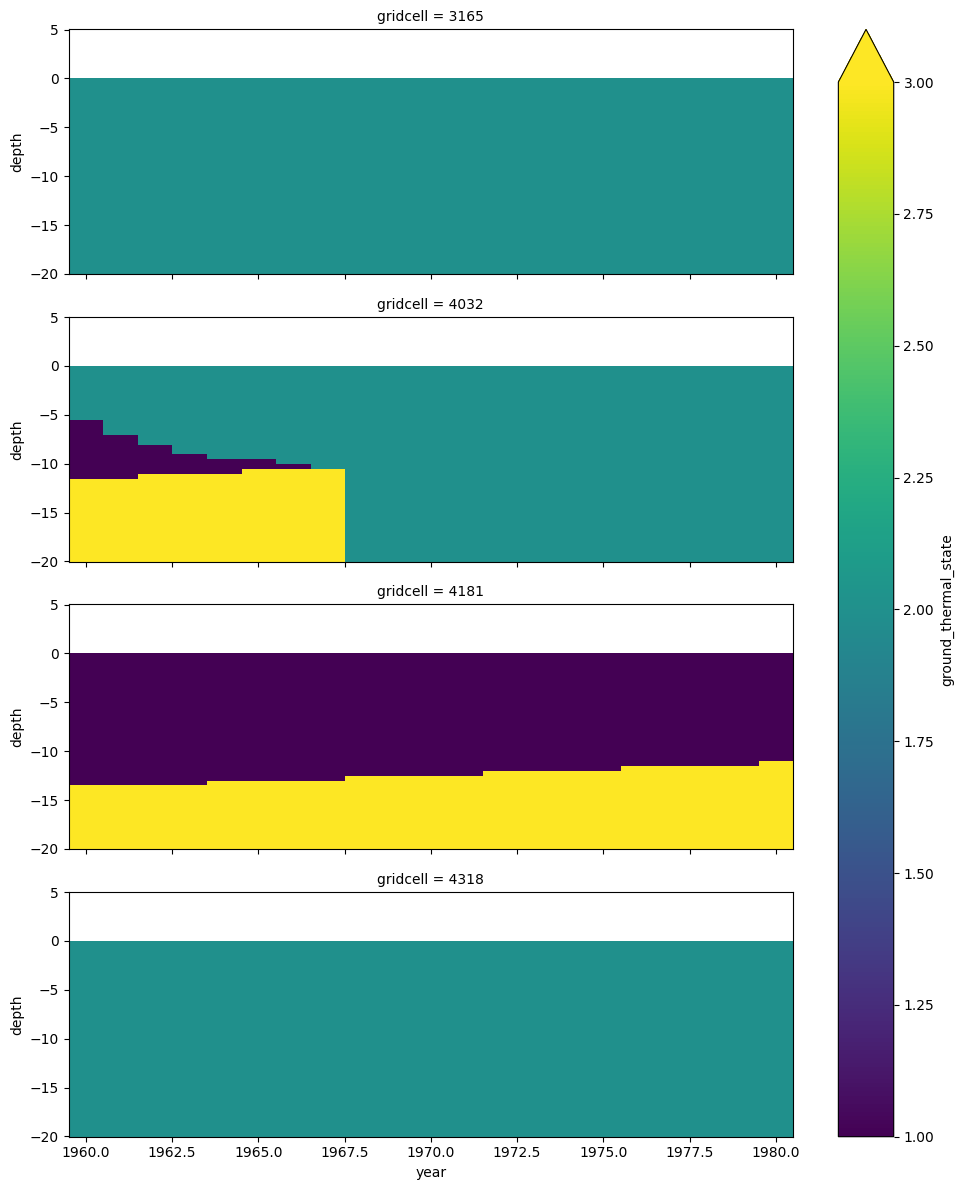

In [63]:
aa.ground_thermal_state.plot.imshow(x='year', y='depth', col='gridcell', col_wrap=1, aspect=3, robust=True)

In [67]:
out.permafrost_thickness #.dropna('gridcell', how='all').plot(hue='gridcell')

<xarray.DataArray 'permafrost_thickness' (gridcell: 4, year: 21)> Size: 672B
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan],
       [6. , 4.5, 3. , 2. , 1.5, 1. , 0.5, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
  * gridcell      (gridcell) int64 32B 3165 4032 4181 4318
  * year          (year) int64 168B 1960 1961 1962 1963 ... 1977 1978 1979 1980
    elevation_0m  (gridcell) float64 32B 3.936e+03 4.276e+03 4.454e+03 4.016e+03